In [18]:
import scanpy as sc
import pandas as pd
import numpy as np

from functools import partial

    
sc.set_figure_params(frameon=False, dpi=150, figsize=(8, 8))

from clustering_utils import ClusterTree, combine_cluster_nodes
from stats_utils import van_elteren_test

### Lets load the data

In [19]:
cluster_tree = ClusterTree.load('../results/neuronal_pruned_cluter_tree_decomp_1000.json')

ClusterTreeNode 'Neurons' loaded from ../results/neuronal_pruned_cluter_tree_decomp_1000.json


In [20]:
adata = sc.read_h5ad('../data/neuronal_raw_embed_propagated.h5ad')

In [21]:
labelmat = cluster_tree.to_labelmat()
columns = [col.split('-')[0] for col in labelmat[0]]
labeldf = pd.DataFrame(
    labelmat,
    index=adata.obs_names,
    columns=columns
)
adata.obs = adata.obs.join(labeldf)
labeldf.head()

,K6,K78,K268,K749,K6594
AAACCCAAGATGCTTC_v2-19-A006200239-175241,K6-4,K78-17,K268-180,K749-47,K6594-3830_K6594-3832_K6594-3833_K6594-3837_K6...
AAACCCAGTACCTAAC_v2-19-A006200239-175241,K6-1,K78-35,K268-91,K749-75,K6594-6274_K6594-6277_K6594-6278_K6594-6279_K6...
AAACCCATCCGAAATC_v2-19-A006200239-175241,K6-4,K78-16,K268-20,K749-208,K6594-1190_K6594-1191_K6594-1194_K6594-1195_K6...
AAACCCATCGTAGAGG_v2-19-A006200239-175241,K6-1,K78-11,K268-125,K749-653,K6594-5544_K6594-5545_K6594-5546_K6594-5547_K6...
AAACCCATCTTAGTTC_v2-19-A006200239-175241,K6-4,K78-50,K268-147,K749-289,K6594-2024_K6594-2025_K6594-2026_K6594-2027_K6...


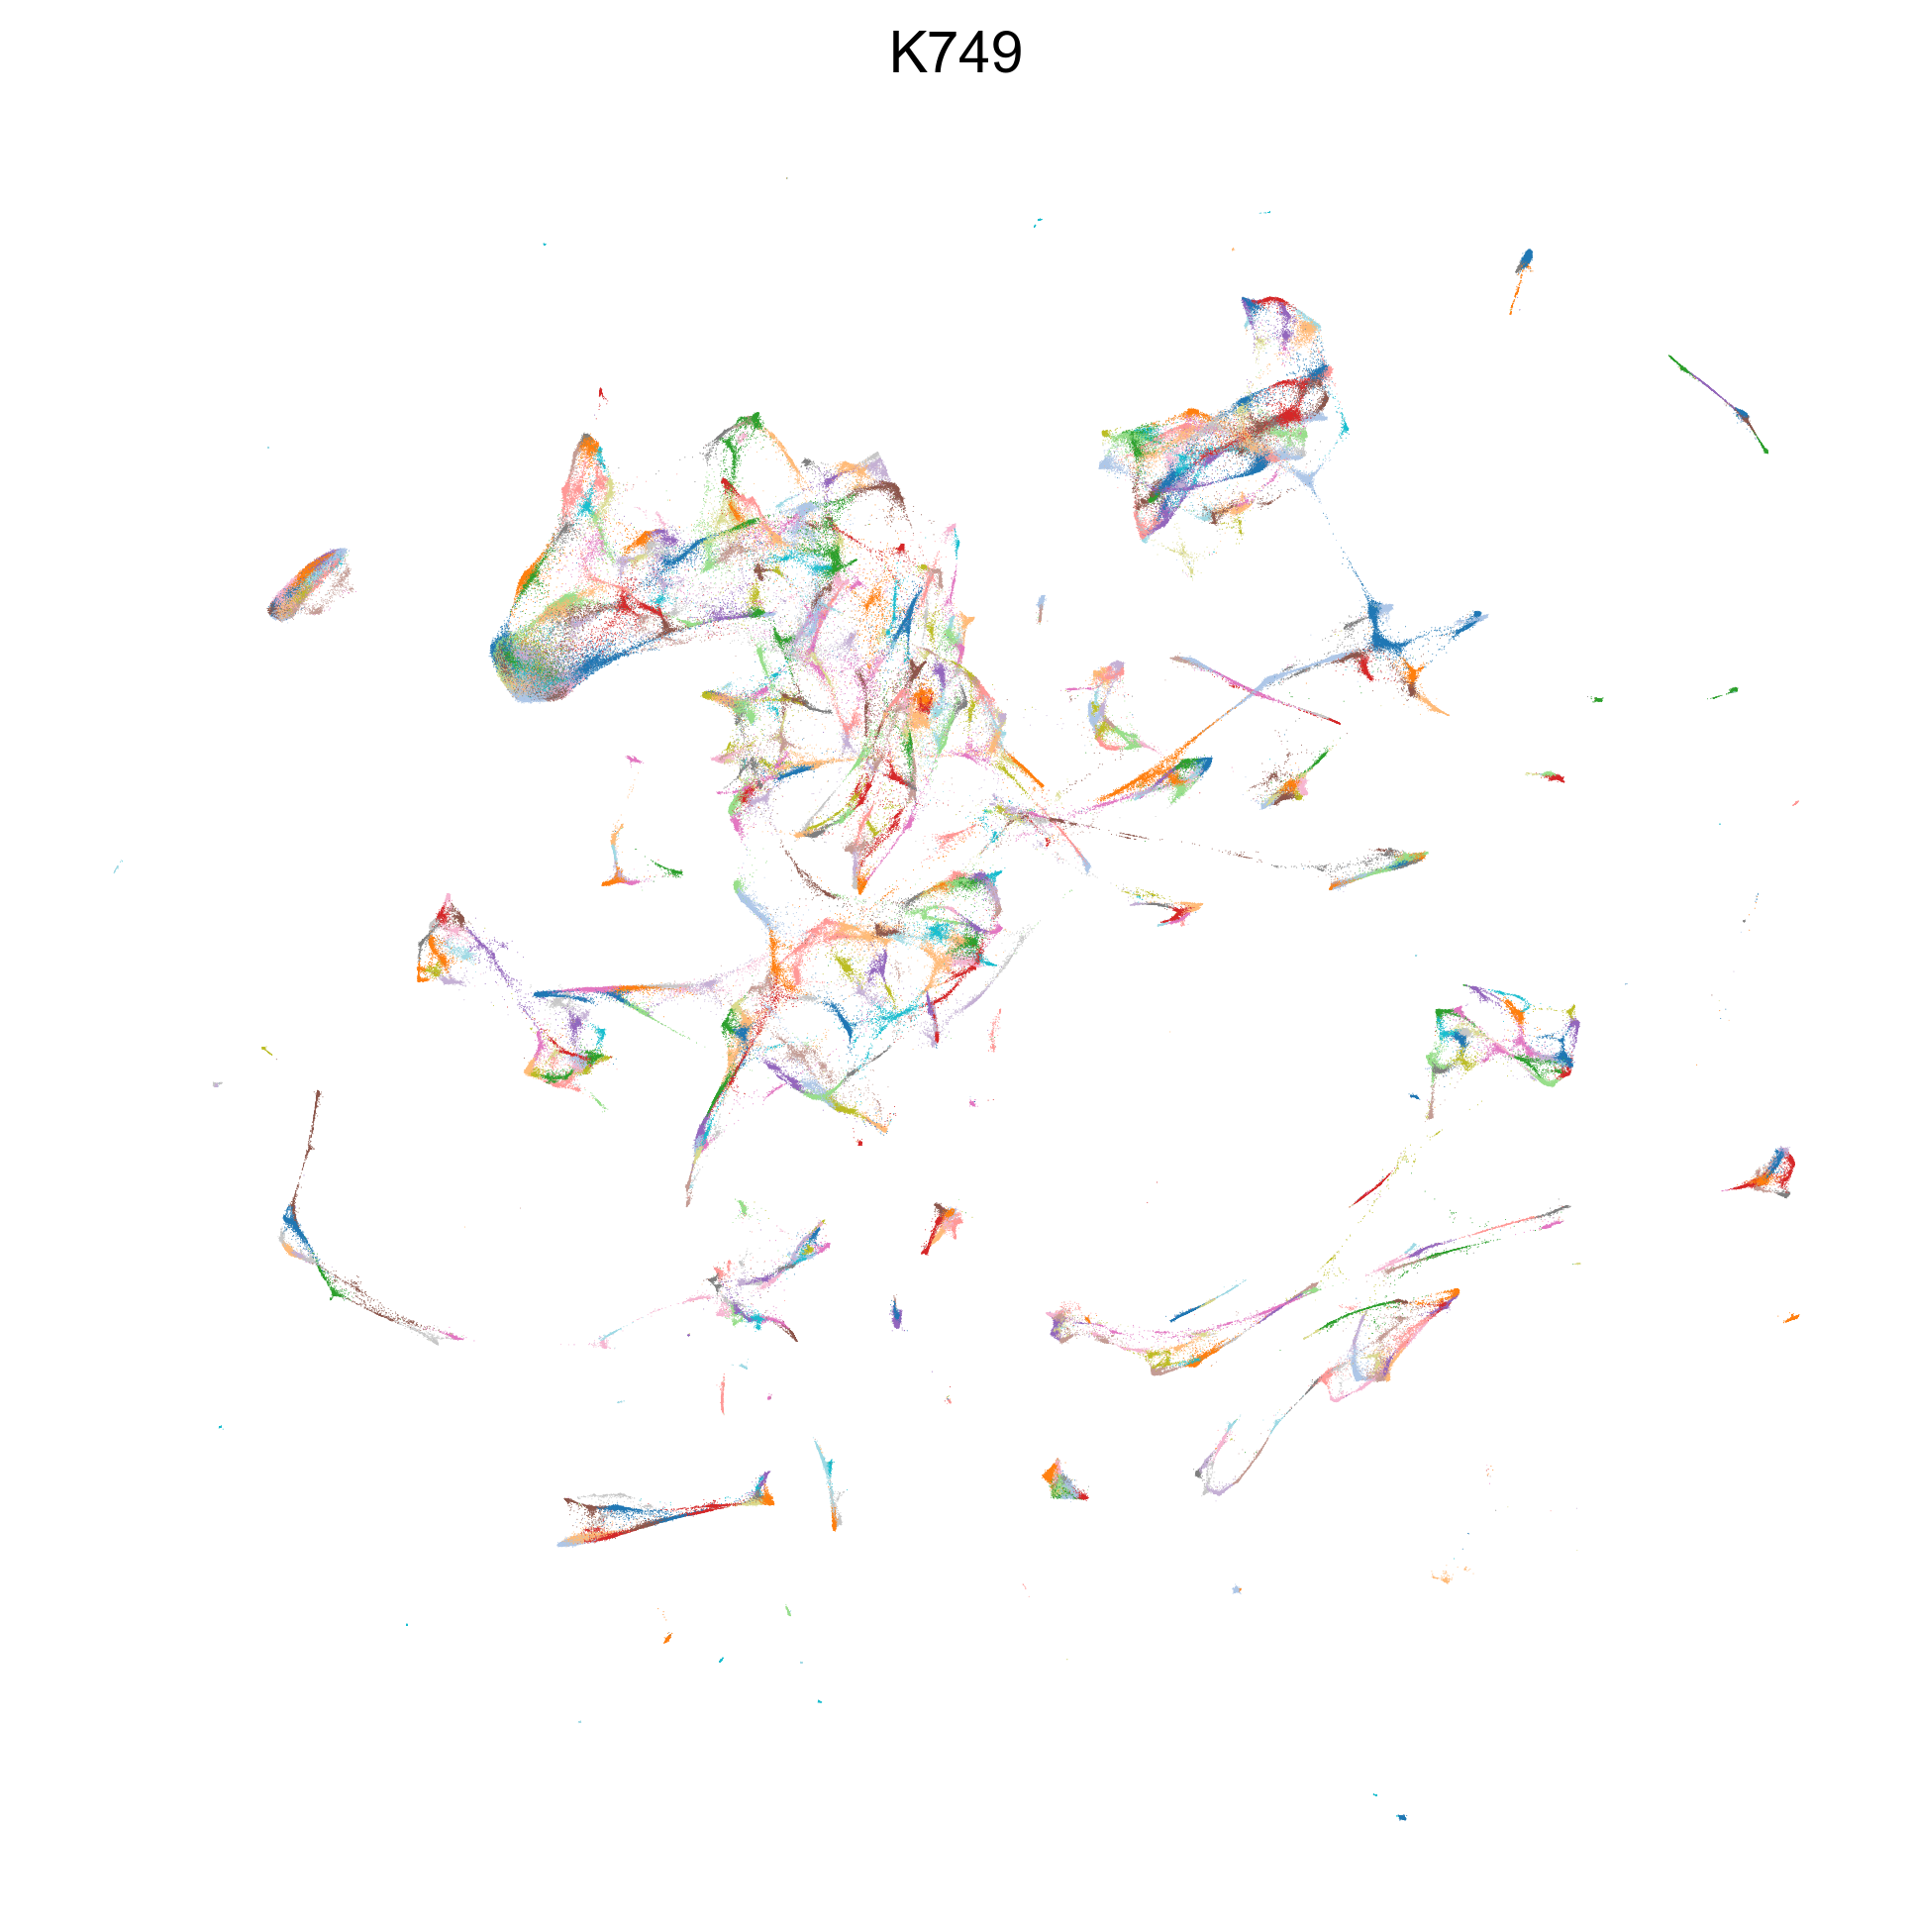

In [22]:
sc.pl.umap(adata, color='K749', palette='tab20', legend_loc=None)

In [24]:
def subsample_strata(adata, strata_key, max_size, min_size=0, random_state=0):
    selected = []
    for stratum in set(adata.obs[strata_key]):
        indices = np.where(adata.obs[strata_key] == stratum)[0]
        if len(indices) > max_size:
            np.random.seed(random_state)
            selected.extend(np.random.choice(indices, max_size).tolist())
        elif len(indices) < min_size:
            pass
        else:
            selected.extend(indices.tolist())
    
    return adata[selected]

pct_expression = lambda X: X.getnnz(axis=0)/X.shape[0]

In [25]:
def run_markers(subset_A: sc.AnnData, 
                subset_B: sc.AnnData,
                strata_key: str,
                max_stratum_size: int = 250,
                min_stratum_size: int = 10,
                min_pct_expression: float = 0.1,
                min_specificity: float = 0.3) -> bool:
    
    # print(f'Checking {clusterA.name} and {clusterB.name}')
    
    # # Get cluster AnnData subsets
    # subset_A = adata[cluster.indexer]
    # subset_B = adata[other.indexer]
    
    n_genes = subset_A.shape[1]
    genes = subset_A.var_names
    
    # Subsample data to reduced strata proportions
    subset_A = subsample_strata(subset_A, strata_key, max_size=max_stratum_size, min_size=min_stratum_size)
    subset_B = subsample_strata(subset_B, strata_key, max_size=max_stratum_size, min_size=min_stratum_size)
    
    # Identify common strata between clusters
    common_strata = set(subset_A.obs[strata_key]).intersection(set(subset_B.obs[strata_key]))
    
    if not common_strata:
        print('No overlapping strata')
        return None
    
    # Update cluster subsets to contain only common strata
    subset_A = subset_A[subset_A.obs[strata_key].isin(common_strata)]
    subset_B = subset_B[subset_B.obs[strata_key].isin(common_strata)]
    
    # Get percentage of cells expressing each gene for both clusters    
    pct_A = pct_expression(subset_A.X)
    pct_B = pct_expression(subset_B.X)
    
    # Create mask for genes that have pct expression > min_pct_expression    
    pct_mask = (pct_A >= min_pct_expression) | (pct_B >= min_pct_expression)
    
    # Calculate absolute specificity for all genes between both clusters
    relative_pct_diff = np.abs(pct_A - pct_B)/(pct_A+pct_B+1e-10)
    avg_log2FC = (np.log2(subset_A.X.mean(axis=0) + 1) - np.log2(subset_B.X.mean(axis=0) + 1)).A1
    specificity = relative_pct_diff * np.abs(avg_log2FC)
    
    # Create mask for genes that have specificity > min_specificity   
    specificity_mask = specificity >= min_specificity
    
    # Any gene with higher enough expression and specificity is parsed to statistical test
    valid_gene_indices = np.where(pct_mask & specificity_mask)[0]
    
    print(f'{len(valid_gene_indices)} valid genes found!')

    # Update cluster subsets to contain only valid genes
    subset_A = subset_A[:, valid_gene_indices]
    subset_B = subset_B[:, valid_gene_indices]

    # Convert to dense for statistics
    exp_A = (np.log1p(subset_A.X)/np.log(2)).toarray() # Can't log2(x+1) sparse matrices
    exp_B = (np.log1p(subset_B.X)/np.log(2)).toarray() # So we cheat with maths trickery ln(x+1)/ln(2) = log2(x+1)

    # Run Van Elteren Test
    fs, ps = van_elteren_test(exp_A, exp_B, subset_A.obs[strata_key], subset_B.obs[strata_key], return_effect_size=True)
    
    ve_stats = np.zeros(n_genes)
    ve_stats[valid_gene_indices] = fs
    
    pvalues = np.ones(n_genes)
    pvalues[valid_gene_indices] = ps
    
    padj = np.clip(pvalues*len(valid_gene_indices), 0, 1) # Bonferroni false positive correction
    
    stat_res = pd.DataFrame({
        'specificity': specificity,
        'avg_log2FC': avg_log2FC,
        'VE_stat': ve_stats,
        'padj': padj,
        'pvalue': pvalues,
        'pctA': pct_A,
        'pctB': pct_B,
        'pct_diff': relative_pct_diff
    }, index=genes)
    
    # If all checks pass then return True, clusters are distinct
    # return sum(significant_mask) >= min_marker_genes
    return stat_res

partial_run_markers = partial(run_markers,
                            # adata=adata,
                            strata_key='Sample',
                            max_stratum_size=1000,
                            min_stratum_size=10,
                            min_pct_expression=0.1,
                            min_specificity=0.1)

### Run through all cluster and compare sisters

In [26]:
all_clusters = cluster_tree.generate_lookup_table()
all_clusters.pop('Neurons')

HierTreeCluster(name='Neurons', level=0, num_members=522212, supercluster='None', subclusters=[K6-5, K6-6, K6-1, K6-2, K6-4, K6-3])

In [ ]:
sister_markers = {}

for name, cluster in all_clusters.items():

    sisters = cluster.get_sisters()
    
    if len(sisters) > 1:
        sisters = combine_cluster_nodes(sisters, 'sisters')
    else:
        sisters = sisters[0]
    
    
    gene_ranking = partial_run_markers(adata[cluster.indexer], adata[sisters.indexer])
    
    markers = gene_ranking[
        (gene_ranking['avg_log2FC'] > 0) &
        (gene_ranking['padj'] < 0.01)
    ].sort_values('specificity', ascending=False)
    
    markers.index.name = 'Gene'
    
    sister_markers[name] = markers.assign(Cluster=cluster.name).reset_index()

In [31]:
pd.concat([table for table in sister_markers.values()]).to_csv('../results/markers_sisters.csv', index=None)

### Run through clusters and compare to all

In [ ]:
all_markers={}

for name, cluster in all_clusters.items():
    
    cluster_mask = np.zeros(adata.shape[0], dtype=bool)
    cluster_mask[cluster.indexer] = True
    
    gene_ranking = partial_run_markers(adata[cluster_mask], adata[~cluster_mask])
    
    markers = gene_ranking[
        (gene_ranking['avg_log2FC'] > 0) &
        (gene_ranking['padj'] < 0.01)
    ].sort_values('specificity', ascending=False)
    
    markers.index.name = 'Gene'
    
    all_markers[name] = markers.assign(Cluster=cluster.name).reset_index()

In [30]:
pd.concat([table for table in all_markers.values()]).to_csv('../results/markers_all.csv', index=None)